In [12]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
import os
import pandas as pd

In [14]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [15]:
torch.cuda.set_device(1)

In [16]:
PATH = 'words/'
csv_path = PATH + 'csv_files/c03.csv'
n = len(list(open(csv_path))) - 1 # -1 to ignore the header line
n

4366

In [17]:

arch = vgg19
sz = 64
bs = 64
val_idxs = get_cv_idxs(n)
tfms = tfms_from_model(arch, sz)

data = ImageClassifierData.from_csv(path = PATH, folder = 'png_files', 
                                    csv_fname = csv_path, bs = bs, 
                                    tfms = tfms, val_idxs = val_idxs, 
                                    test_name = None )

In [18]:
# comparing instances of dataset object and original data

# picking first image (index 0)
x1 = data.trn_ds.get_x(0)

# picking file name of first image
path = data.trn_ds.fnames[0]
x2 = plt.imread(PATH + path)
# image in grayscale, repeat it 3 times to get RGB values
x2 = np.stack((x2, x2, x2), axis = 2)



(-0.5, 122.5, 97.5, -0.5)

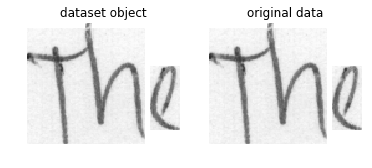

In [19]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x1)
ax[0].axis('off')
ax[0].set(title = 'dataset object')
ax[1].imshow(x2)
ax[1].set(title = 'original data')
ax[1].axis('off')

In [20]:
fn = [PATH + data.trn_ds.fnames[0]]; fn

['words/png_files/c03-000a-00-00.png']

In [21]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz)
    return ImageClassifierData.from_csv(path = PATH, folder = 'png_files', 
                                    csv_fname = csv_path, 
                                    tfms = tfms, val_idxs = val_idxs, 
                                    test_name = None )

In [22]:
learn = ConvLearner.pretrained(arch, data)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /home/pedro2/.torch/models/vgg19_bn-c79401a0.pth
100%|██████████| 574769405/574769405 [00:34<00:00, 16526284.07it/s]


 93%|█████████▎| 51/55 [00:40<00:03,  1.27it/s, loss=38.7]

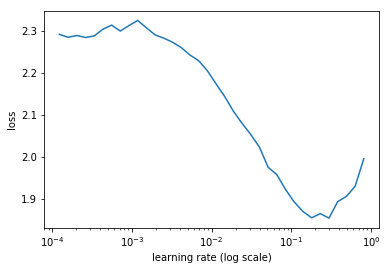

In [23]:
lrf=learn.lr_find()
learn.sched.plot()

In [24]:
lr = 0.02
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                 
    0      1.124846   0.730756   0.760596  
    1      0.88674    0.563075   0.808706                  
    2      0.74178    0.518658   0.815578                  
    3      0.69838    0.469269   0.838488                  
    4      0.650012   0.444966   0.835052                  
    5      0.589293   0.42474    0.854525                  
    6      0.591653   0.428121   0.859107                  


[array([0.42812]), 0.8591065301654811]

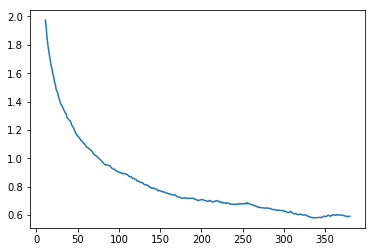

In [25]:
learn.sched.plot_loss()

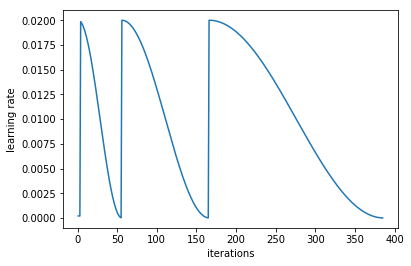

In [26]:
learn.sched.plot_lr()

In [27]:
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.415193   0.154153   0.942726  
    1      0.262223   0.125104   0.955326                  
    2      0.177911   0.10248    0.959908                  
    3      0.158833   0.157266   0.938144                  
    4      0.13617    0.114968   0.962199                  
    5      0.11291    0.070408   0.9748                    
    6      0.082348   0.073693   0.973654                   


[array([0.07369]), 0.9736540658230907]

In [28]:
learn.save(f'{sz}')

In [29]:
tmfs = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)

In [30]:
data = ImageClassifierData.from_csv(path = PATH, folder = 'png_files', 
                                    csv_fname = csv_path, 
                                    tfms = tfms, val_idxs = val_idxs, 
                                    test_name = None )

In [31]:
learn_data_agumentation = ConvLearner.pretrained(arch, data)

 95%|█████████▍| 52/55 [00:19<00:01,  2.68it/s, loss=10.9]

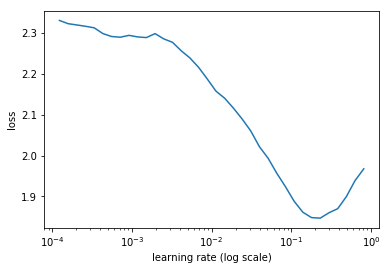

In [32]:
lrf=learn_data_agumentation.lr_find()
learn_data_agumentation.sched.plot()

In [33]:
lr = 0.02
learn_data_agumentation.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                 
    0      1.143551   0.740127   0.741123  
    1      0.914224   0.554633   0.810997                  
    2      0.765466   0.520475   0.822451                  
    3      0.726413   0.482118   0.83047                   
    4      0.653685   0.452821   0.838488                  
    5      0.604152   0.432985   0.848797                  
    6      0.56841    0.430228   0.854525                  


[array([0.43023]), 0.8545246269694718]

In [34]:
lrs = np.array([lr/9,lr/3,lr])
learn_data_agumentation.unfreeze()
learn_data_agumentation.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.413478   0.163433   0.940435  
    1      0.257716   0.110588   0.963345                  
    2      0.17177    0.097081   0.967927                  
    3      0.173306   0.099639   0.962199                  
    4      0.1435     0.081224   0.965636                  
    5      0.099482   0.068866   0.97709                    
    6      0.074579   0.067136   0.975945                   


[array([0.06714]), 0.975945018274541]

In [35]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [36]:
accuracy_np(preds, y)

0.979381443298969

In [37]:
multi_preds, y = learn_data_agumentation.TTA()
preds = np.mean(multi_preds, 0)

In [38]:
accuracy_np(preds,y)

0.9805269186712485